# Saves Analysis

### MSP, 4.21.2017

A struggle to understand exactly what we can use, apart from manager proclamations, to understand save propensity.

In [1]:
from IPython.display import HTML
HTML('''<script>code_show=true; function code_toggle() { if (code_show){ $('div.input').hide();} else { $('div.input').show(); } code_show = !code_show} $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
# basic imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl


%matplotlib inline

In [2]:
# read in fangraphs-ripped stats. specifications:
#    fangraphs-denoted starter


def read_individual_standard_stats(infile):
    return np.genfromtxt(infile,\
                  dtype={'names': ("Name","Team","W","L","ERA","G","GS","CG","ShO",\
                                   "SV","HLD","BS","IP","TBF","H","R","ER","HR","BB",\
                                   "IBB","HBP","WP","BK","SO","playerid"),\
                         'formats': ('S20','S20','f4','f4','f4','f4','f4','f4','f4',\
                                    'i2','i2','i2','f4','i2','i2','i2','i2','i2','f4',\
                                    'f4','f4','f4','f4','f4','i4')},\
                 skip_header=1,delimiter=',')

def read_individual_battedball_stats(infile):
    return np.genfromtxt(infile,\
                  dtype={'names': ("Name","Team","BABIP","GB/FB","LD","GB","FB","IFFB","HRFB",\
                                   "RS","RS9","BLLS","STRKS","PIT","PULL","CENT","OPPO",\
                                   "SOFT","MED","HARD","playerid"),\
                         'formats': ('S20','S20','f4','f4','f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','f4','f4','f4','f4','f4',\
                                    'f4','f4','f4','i4')},\
                 skip_header=1,delimiter=',')


RelieversPlayers2016 = read_individual_standard_stats('2016Pitching/Relievers2016.csv')
RelieversBatted2016  = read_individual_battedball_stats('2016Pitching/RelieversBatted2016.csv')





In [3]:

#
# calculate some extra stats
#

#FIP = ((13*HR)+(3*(BB+HBP))-(2*K))/IP + constant


SP2016FIP  = (13.*RelieversPlayers2016['HR'] +\
              (3.*(RelieversPlayers2016['BB'] + RelieversPlayers2016['HBP'])) -\
              2.*RelieversPlayers2016['SO'])\
                /RelieversPlayers2016['IP'] + 3.1437 # 3.143 is the 2016 correction
    
SP2016WHIP = (RelieversPlayers2016['BB'] + RelieversPlayers2016['H'])/RelieversPlayers2016['IP']
SP2016HIP = (RelieversPlayers2016['H'])/RelieversPlayers2016['IP']




In [6]:


#
# match the player stats across datasets
#
PlayerDict = {}
PlayerDict['Player'] = RelieversPlayers2016['Name']
PlayerDict['WHIP'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['BABIP'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['FIP'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['HIP'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['ERA'] = np.zeros(len(RelieversPlayers2016['Name']))
PlayerDict['ST'] = np.zeros(len(RelieversPlayers2016['Name']))

#
# also add a 100 IP threshold
#
for x in range(0,len(PlayerDict['Player'])):
    if RelieversPlayers2016['IP'][x] > 40.:
        PlayerDict['WHIP'][x] = SP2016WHIP[x]
        PlayerDict['FIP'][x] = SP2016FIP[x]
        PlayerDict['HIP'][x] = SP2016HIP[x]
        PlayerDict['ERA'][x] = RelieversPlayers2016['ERA'][x]
 
        try:
            xx = np.where(RelieversPlayers2016['Name'][x] == RelieversBatted2016['Name'])[0]
            PlayerDict['BABIP'][x] = \
              RelieversBatted2016['BABIP'][xx]
            PlayerDict['ST'][x] = RelieversBatted2016['STRKS'][xx]/RelieversBatted2016['PIT'][xx]
        except:
            PlayerDict['BABIP'][x] = np.nan
            PlayerDict['ST'][x] = np.nan
    else:
        PlayerDict['WHIP'][x] = np.nan
        PlayerDict['FIP'][x] = np.nan
        PlayerDict['HIP'][x] = np.nan
        PlayerDict['BABIP'][x] = np.nan

You're a smart baseball fan, you know that ERA and WHIP correlate. There's dispersion, sure, but there are ways to try and mitigate that. For instance, the fraction of strikes thrown tells you something about the pitcher's control; sure enough, it helps explain a lot of the dispersion in the ERA-WHIP plane. The actual values are suble--everyone throws between 60 and 70 percent strikes--so the Strike% quantity can take a while to settle down.

That said, it's the close of first week of the season! Of course we are going to hit the small sample sizes hard.

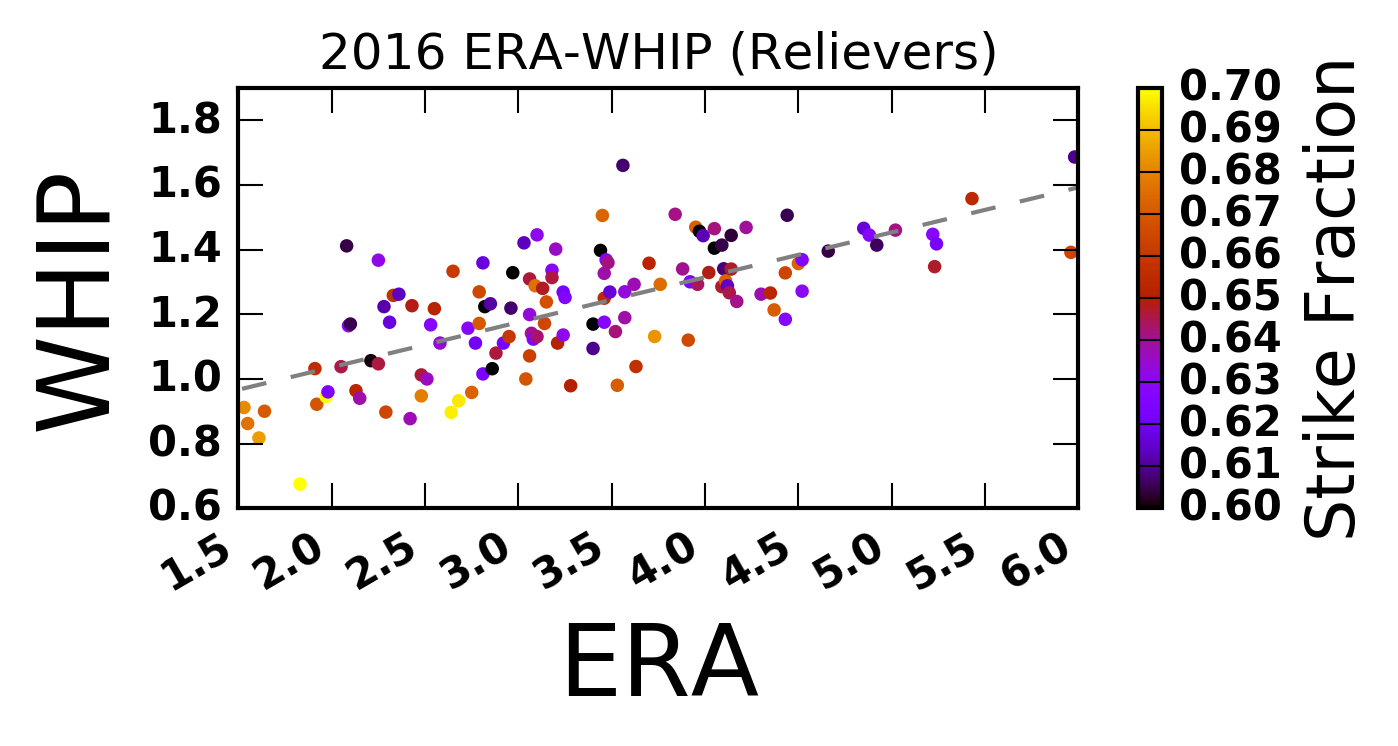

In [8]:

fig = plt.figure(figsize=(4,2))

ax = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])

# find valid values and plot
goodw = np.where(PlayerDict['BABIP'] > 0.)[0]
ax.scatter(PlayerDict['ERA'][goodw],PlayerDict['WHIP'][goodw],\
            color=cm.gnuplot((PlayerDict['ST'][goodw] - 0.6)/0.1,1.),s=5.)


ax.axis([1.5,6.,0.6,1.9])
ax.set_ylabel('WHIP',size=24)
ax.set_xlabel('ERA',size=24)
for label in ax.get_xticklabels(): label.set_rotation(30); label.set_horizontalalignment("right")

ax.set_title('2016 ERA-WHIP (Relievers)')



# fit a linear model to valid values
goodw = np.where(PlayerDict['ERA'] > 0.)[0]
c = np.polyfit(PlayerDict['ERA'][goodw],PlayerDict['WHIP'][goodw],1)
d = np.poly1d(c)
ax.plot(np.linspace(0.0,6.0,100),d(np.linspace(0.0,6.0,100)),color='gray',lw=1.,linestyle='dashed')

cmap = mpl.cm.gnuplot; norm = mpl.colors.Normalize(vmin=0.6, vmax=0.7)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Strike Fraction',size=16)





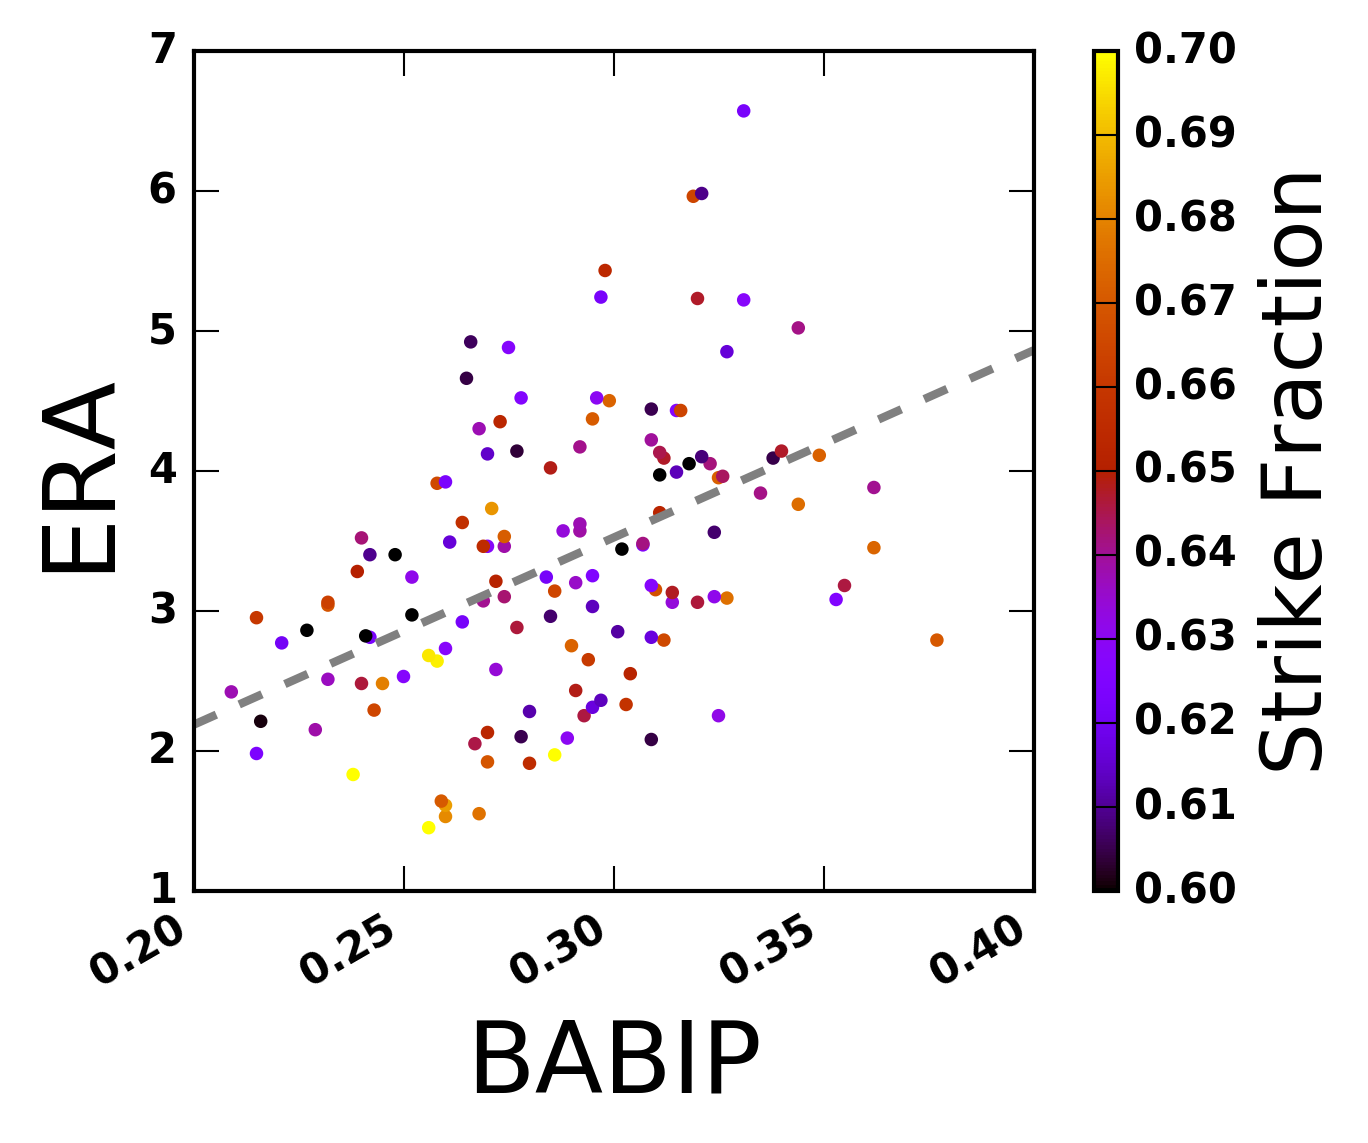

In [9]:


fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])

# find only pitchers with batted ball data
goodw = np.where(PlayerDict['BABIP'] > 0.)[0]

ax.scatter(PlayerDict['BABIP'][goodw],PlayerDict['ERA'][goodw],\
           color=cm.gnuplot((PlayerDict['ST'][goodw] - 0.6)/0.1,1.),s=5.)

cmap = mpl.cm.gnuplot; norm = mpl.colors.Normalize(vmin=0.6, vmax=0.7)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Strike Fraction',size=20)

c = np.polyfit(PlayerDict['BABIP'][goodw],PlayerDict['ERA'][goodw],1)
d = np.poly1d(c)

ax.plot(np.linspace(.2,.4,100),d(np.linspace(.2,.4,100)),color='gray',linestyle='dashed')

ax.axis([0.2,0.4,1.,7.])
ax.set_ylabel('ERA',size=24)
ax.set_xlabel('BABIP',size=24)

for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment("right")


The next step is to set up the regression to see what we might expect from players going forward. I've already fit a simple linear model in the figure above, so let's use it to look at outliers:

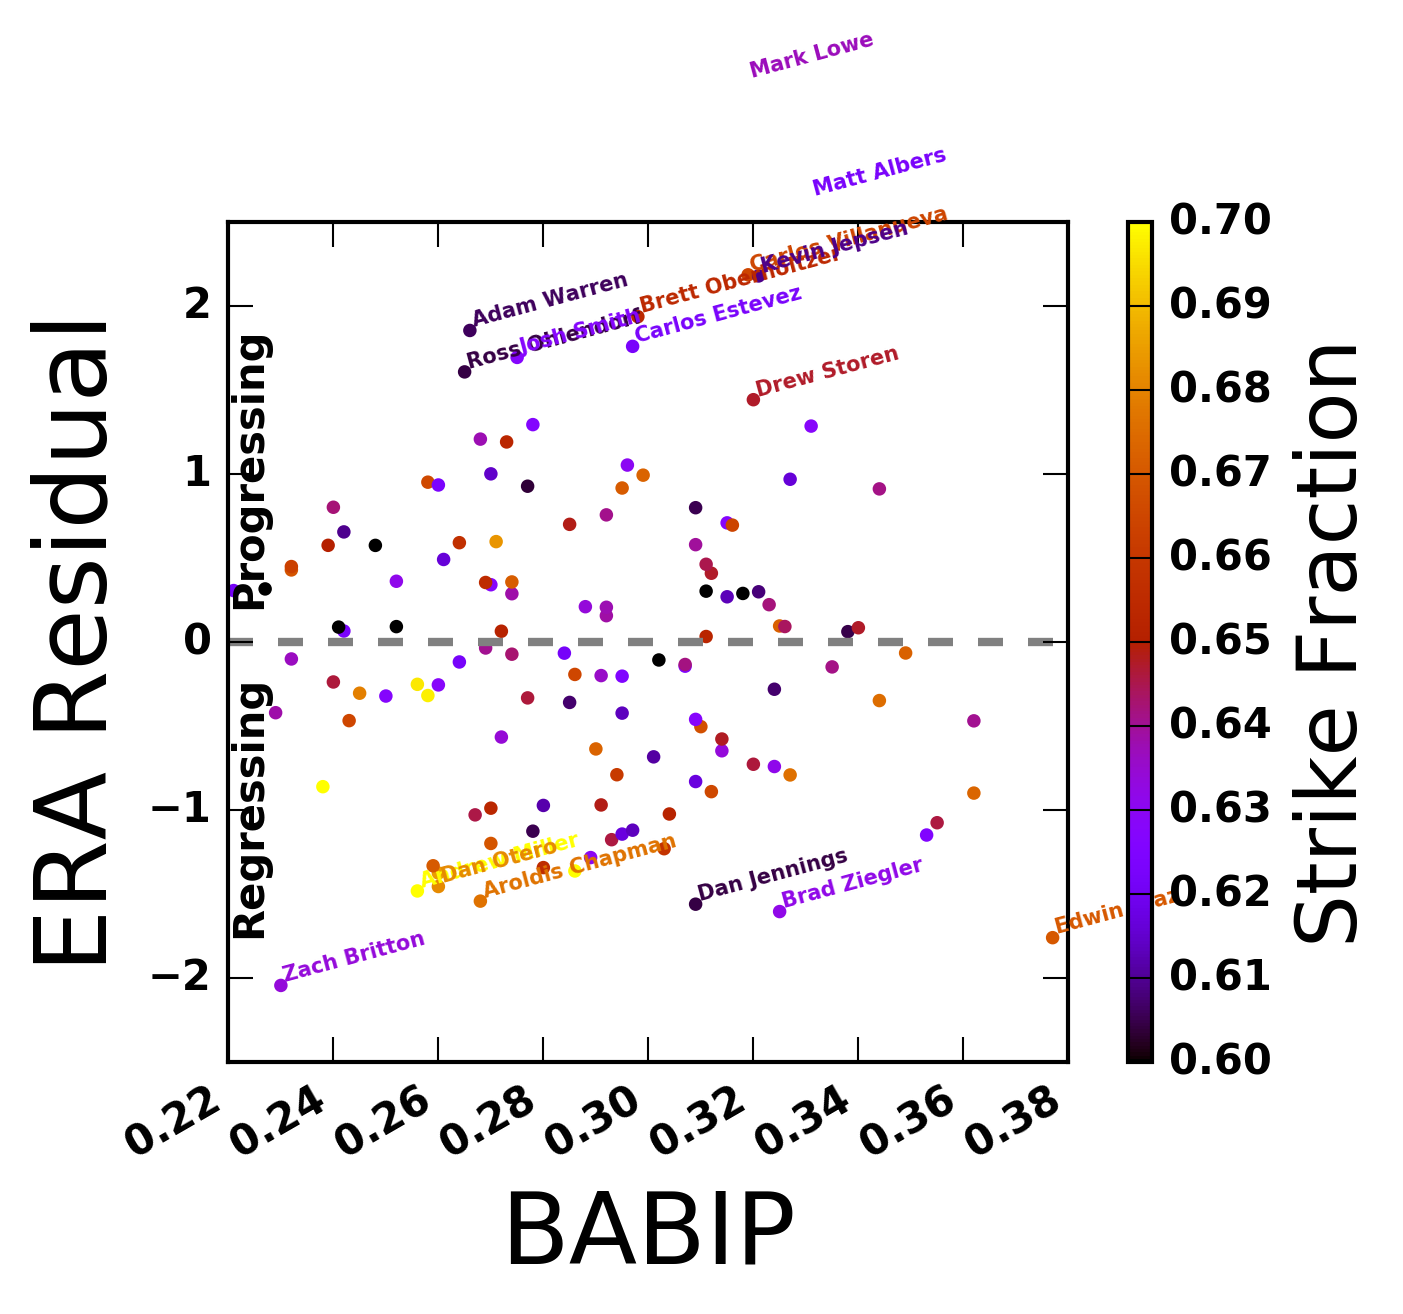

In [10]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])


goodw = np.where(PlayerDict['BABIP'] > 0.)[0]



model = PlayerDict['ERA'][goodw] - d(PlayerDict['BABIP'][goodw])
cbar = ax.scatter(PlayerDict['BABIP'][goodw],model,\
                  color=cm.gnuplot((PlayerDict['ST'][goodw] - 0.6)/0.1,1.),s=5.)

ax.plot([0.22,0.38],[0.,0.],color='gray',linestyle='dashed')

ax.axis([0.22,0.38,-2.5,2.5])
ax.set_xlabel('BABIP',size=24)
ax.set_ylabel('ERA Residual',size=24)
ax.text(0.22,-0.2,'Regressing',rotation=90,va='top')
ax.text(0.22,0.2,'Progressing',rotation=90,va='bottom')

for indx in goodw:
    modval = PlayerDict['ERA'][indx] - d(PlayerDict['BABIP'][indx])
    if (PlayerDict['BABIP'][indx] > 0.0) & (modval > 1.36):
        ax.text(PlayerDict['BABIP'][indx],modval,PlayerDict['Player'][indx],size=5,rotation=15,ha='left',va='bottom',color=cm.gnuplot((PlayerDict['ST'][indx]-0.6)/0.1,1.))
    if (PlayerDict['BABIP'][indx] > 0.0) & (modval < -1.4):
        ax.text(PlayerDict['BABIP'][indx],modval,PlayerDict['Player'][indx],size=5,rotation=15,ha='left',va='bottom',color=cm.gnuplot((PlayerDict['ST'][indx] -0.6)/0.1,1.))


cmap = mpl.cm.gnuplot
norm = mpl.colors.Normalize(vmin=0.6, vmax=0.7)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Strike Fraction',size=20)

for label in ax.get_xticklabels(): label.set_rotation(30); label.set_horizontalalignment("right")

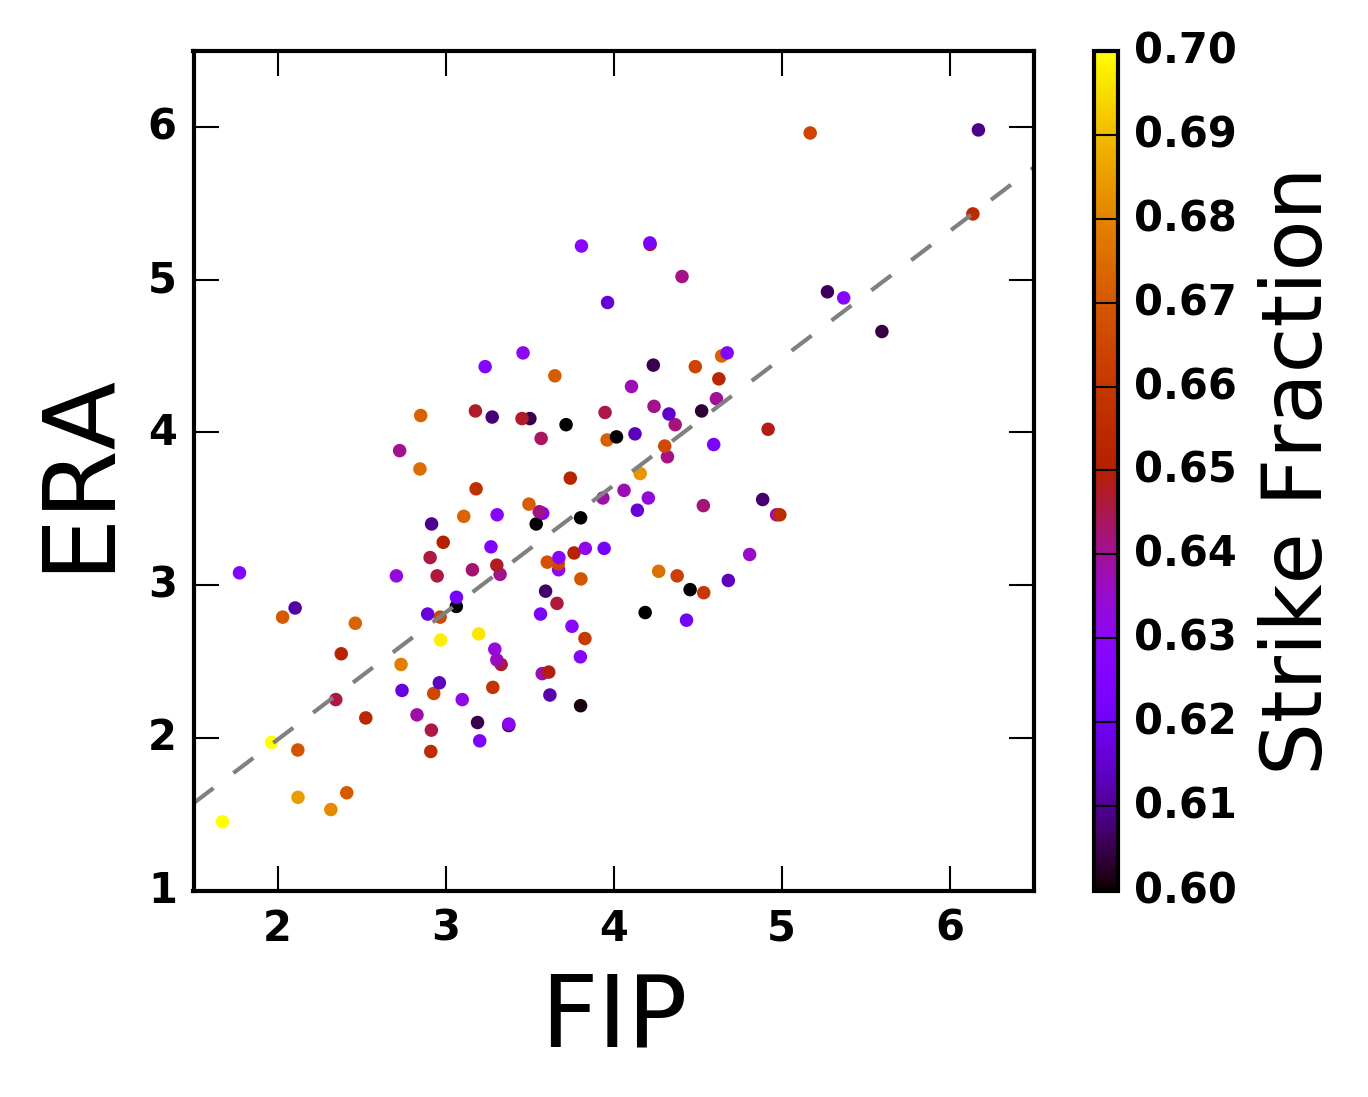

In [11]:

fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])


goodw = np.where(PlayerDict['BABIP'] > 0.)[0]



ax.scatter(PlayerDict['FIP'][goodw],PlayerDict['ERA'][goodw],\
           color=cm.gnuplot((PlayerDict['ST'][goodw] - 0.6)/0.1,1.),s=5.)


c = np.polyfit(PlayerDict['FIP'][goodw],PlayerDict['ERA'][goodw],1)
d = np.poly1d(c)
ax.plot(np.linspace(1.5,6.5,100),d(np.linspace(1.5,6.5,100)),color='gray',lw=1.,linestyle='dashed')

ax.axis([1.5,6.5,1.,6.5])
ax.set_xlabel('FIP',size=24)
ax.set_ylabel('ERA',size=24)

cmap = mpl.cm.gnuplot; norm = mpl.colors.Normalize(vmin=0.6, vmax=0.7)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Strike Fraction',size=20)



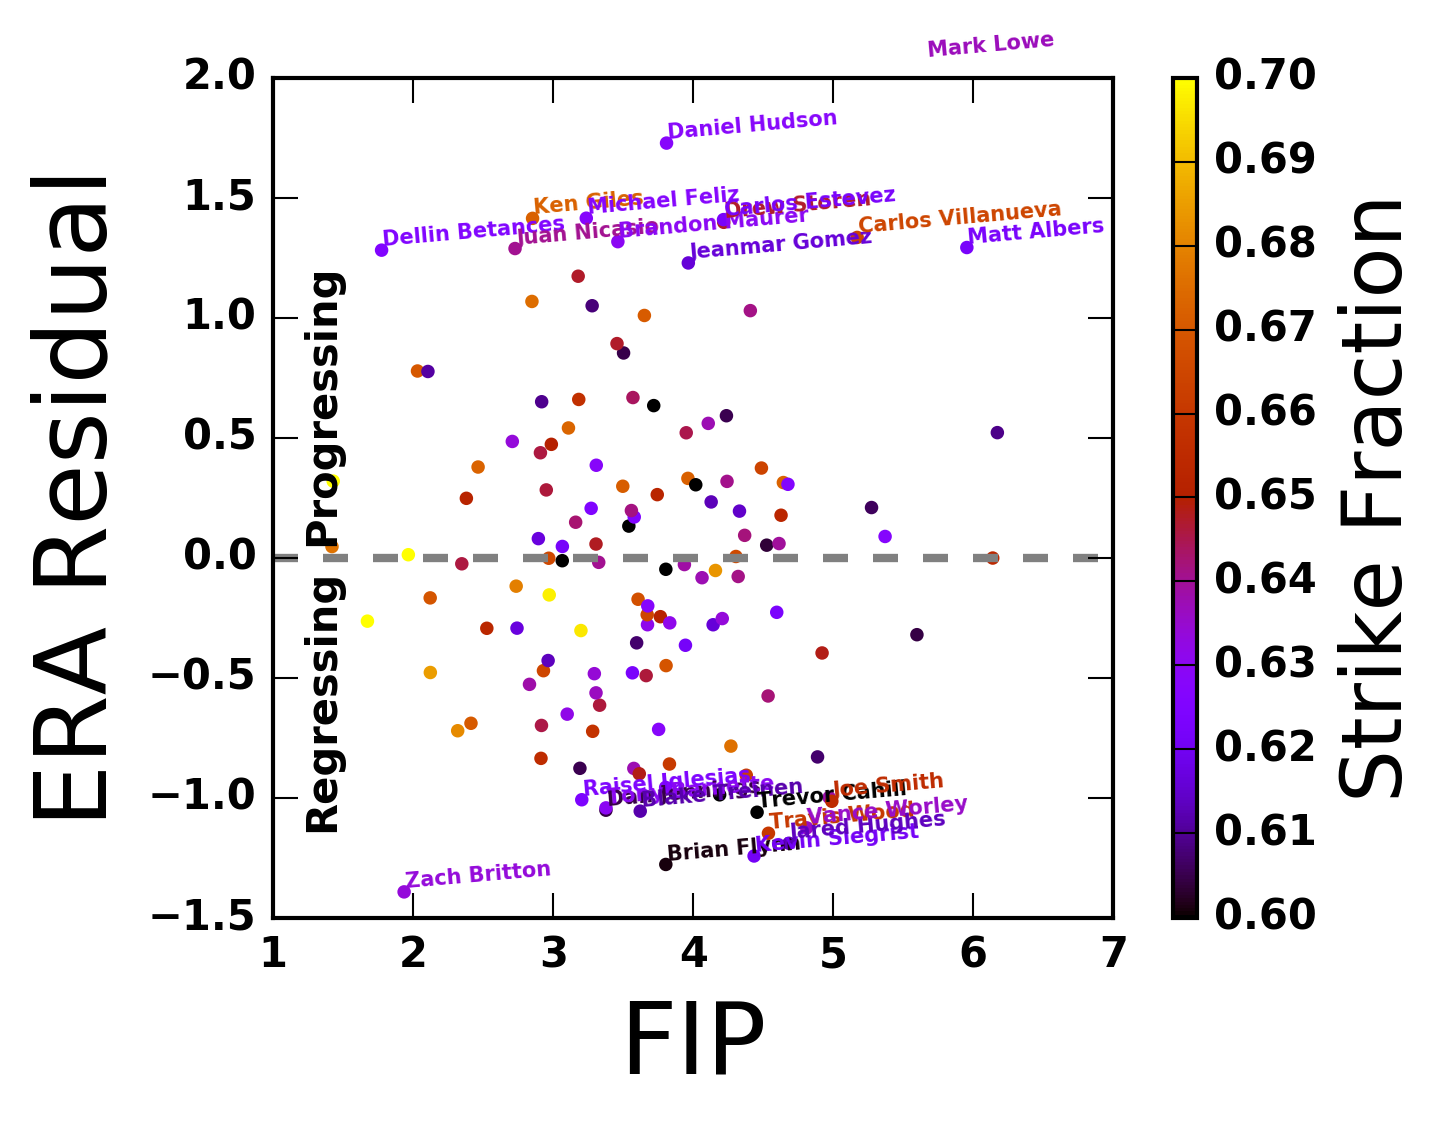

In [12]:

fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0.15,0.15,0.7,0.7])
ax2 = fig.add_axes([0.9,0.15,0.02,0.7])


goodw = np.where(PlayerDict['BABIP'] > 0.)[0]


model = PlayerDict['ERA'][goodw] - d(PlayerDict['FIP'][goodw])
ax.scatter(PlayerDict['FIP'][goodw],model,\
           color=cm.gnuplot((PlayerDict['ST'][goodw] - 0.6)/0.1,1.),s=5.)


ax.plot([1.,7.],[0.,0.],color='gray',linestyle='dashed')

ax.axis([1.,7.,-1.5,2.])
ax.set_xlabel('FIP',size=24)
ax.set_ylabel('ERA Residual',size=24)
ax.text(1.2,-0.05,'Regressing',rotation=90,va='top')
ax.text(1.2,0.05,'Progressing',rotation=90,va='bottom')


for indx in goodw:
    modval = PlayerDict['ERA'][indx] - d(PlayerDict['FIP'][indx])
    if (PlayerDict['FIP'][indx] > 0.0) & (modval > 1.2):
        ax.text(PlayerDict['FIP'][indx],modval,PlayerDict['Player'][indx],size=5,rotation=5,ha='left',va='bottom',color=cm.gnuplot((PlayerDict['ST'][indx]-0.6)/0.1,1.))
    if (PlayerDict['FIP'][indx] > 0.0) & (modval < -1.0):
        ax.text(PlayerDict['FIP'][indx],modval,PlayerDict['Player'][indx],size=5,rotation=5,ha='left',va='bottom',color=cm.gnuplot((PlayerDict['ST'][indx] -0.6)/0.1,1.))


cmap = mpl.cm.gnuplot; norm = mpl.colors.Normalize(vmin=0.6, vmax=0.7)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Strike Fraction',size=20)


